# Clustering

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster.elbow import KElbowVisualizer 
from yellowbrick.cluster import silhouette_visualizer, intercluster_distance 

# Visualization
import plotly.express as px
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.templates.default = "seaborn"

In [2]:
df_players = pd.read_csv("./datasets/players.csv", index_col=0)
#df_players = df_players[df_players.gender == "f"]

## Features preparation

In [3]:
feautures = ['lrpOnMxrp', 'matches_won_ratio', 'mean_rank_points', 'variance_rank_points', 'max_tourney_revenue']
#feautures = ['lrpOnAvgrp', 'lrpOnMxrp', 'variance_rank_points', 'max_tourney_revenue'] # Sil:  0.5278228177769032
#['lrpOnAvgrp', 'lrpOnMxrp', 'matches_won_ratio', 'mean_rank_points', 'variance_rank_points', 'mean_tourney_spectators', 'max_tourney_revenue', 'rel_ptsWon']
#['lrpOnAvgrp', 'lrpOnMxrp', 'variance_rank_points', 'max_tourney_revenue']
#['matches_won_ratio', 'mean_rank_points', 'mean_tourney_spectators', 'mean_tourney_revenue'] -> Siluette score

# Plots
# for feature in feautures:
#     df_players[feature].hist().show()

### Transformations

In [4]:
df_players['mean_rank_points'] = np.log(df_players['mean_rank_points'])
df_players['variance_rank_points'] = np.log1p(df_players['variance_rank_points'])

df_players['mean_rank_points'].hist().show()
df_players['variance_rank_points'].hist().show()

### Normalization

In [5]:
df_data = df_players[feautures].reset_index(drop=True)
df_data = pd.DataFrame(MinMaxScaler().fit_transform(df_data), columns=df_data.columns)
#df_data = pd.DataFrame(RobustScaler(unit_variance=True).fit_transform(df_data), columns=df_data.columns)
#df_data = df_data[(np.abs(stats.zscore(df_data)) < 2).all(axis=1)]
#df_data = pd.DataFrame(QuantileTransformer().fit_transform(df_data), columns=df_data.columns)
df_data = df_data.round(3)

df_data.boxplot(column=feautures)

## PCA

In [6]:
# # PCA
# pca = PCA(n_components=2)
# components = pca.fit_transform(df_data)
# components_df = pd.DataFrame(components)

# # Cluster on PCA
# model = KMeans()
# sse_visualizer = KElbowVisualizer(model, k=(2,8), timings=False)
# sse_visualizer.fit(components_df.iloc[:,:3])

# kmeans = KMeans(n_clusters=sse_visualizer.elbow_value_, n_init=10, max_iter=100, init="k-means++")
# kmeans.fit(components_df.iloc[:,:3])

# px.bar(x=range(pca.n_components), y=pca.explained_variance_ratio_, title="Explained variances").show()
# px.scatter(x=components_df[0], y=components_df[1], color=kmeans.labels_.astype(str))

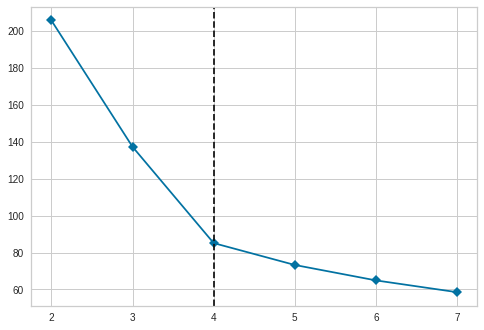

In [7]:
# PCA
pca = PCA(n_components=3)
components = pca.fit_transform(df_data)
components_df = pd.DataFrame(components)

# Cluster on PCA
model = KMeans()
sse_visualizer = KElbowVisualizer(model, k=(2,8), timings=False)
sse_visualizer.fit(components_df.iloc[:,:4])

kmeans = KMeans(n_clusters=sse_visualizer.elbow_value_, n_init=10, max_iter=100, init="k-means++")
kmeans.fit(components_df.iloc[:,:4])

px.bar(x=range(pca.n_components), y=pca.explained_variance_ratio_, title="Explained variances").show()
px.scatter_3d(x=components_df[0], y=components_df[1], z=components_df[2], color=kmeans.labels_.astype(str))

## K-means

### Find Optimal K

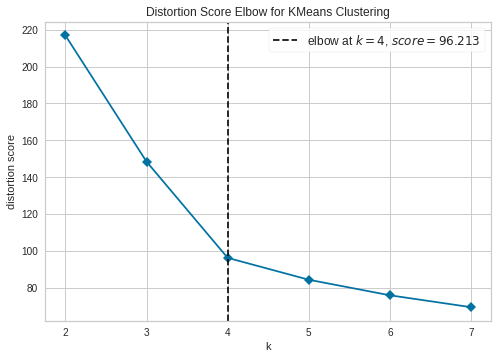

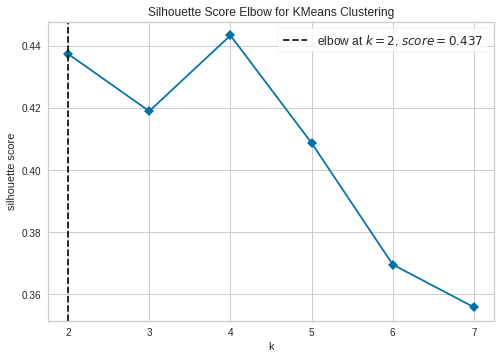

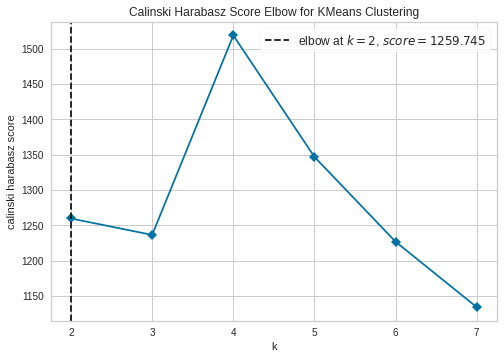

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [18]:
model = KMeans()
sse_visualizer = KElbowVisualizer(model, k=(2,8), timings=False)
sse_visualizer.fit(df_data)
sse_visualizer.show()

sil_visualizer = KElbowVisualizer(model, k=(2,8), timings=False, metric="silhouette")
sil_visualizer.fit(df_data)
sil_visualizer.show()

Picking optimal K

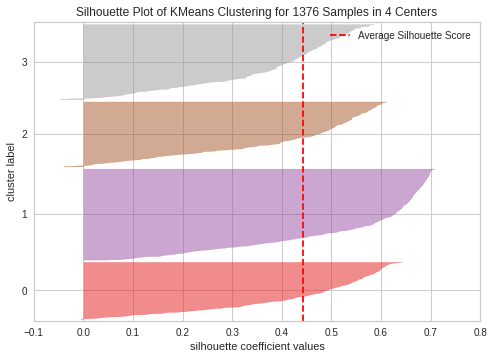

The silhoutte score is: 0.442909050725638


In [19]:
optimal_k = sse_visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_k, n_init=10, max_iter=100, init="k-means++")
kmeans.fit(df_data)

df_players["cluster"] = kmeans.labels_.astype(str)
df_players = df_players.round(3)

x = silhouette_visualizer(KMeans(optimal_k, random_state=42), df_data)
print("The silhoutte score is: " + str(x.silhouette_score_))

/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



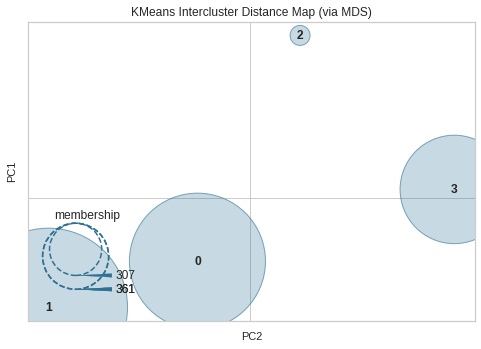

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(max_iter=100, n_clusters=4))

In [12]:
intercluster_distance(kmeans, df_data)

### Result analysis

#### Cluster distribution

In [13]:
df_players.groupby("cluster").count()["name"].plot.bar()

#### Interpretatation

In [14]:
pd.set_option('display.max_columns', None)
df_players.groupby("cluster").mean()

,total_tourneys_played,total_matches_played,total_matches_won,matches_won_ratio,mean_performance_index,max_performance_index,min_performance_index,ht,age,mean_minutes,max_minutes,minutes_entropy,mean_rank_points,max_rank_points,last_rank_points,variance_rank_points,mean_tourney_spectators,max_tourney_spectators,mean_tourney_revenue,max_tourney_revenue,rel_ace,rel_df,rel_1stIn,rel_1stWon,rel_2ndWon,1WonOn1In,1WonOnTotWon,rel_ptsWon,rel_bpFaced,rel_bpSaved,rel_gmsWon,lrpOnAvgrp,lrpOnMxrp
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,91.000000,189.036011,100.160665,0.519972,0.296230,0.827560,0.000000,181.104712,25.802975,96.892618,200.634349,4.699939,6.090438,1298.221607,404.797784,10.367895,5075.346975,16573.548476,1.012758e+06,4.286814e+06,0.054659,0.047355,0.613025,0.409438,0.184155,0.669427,0.689892,0.498515,0.051906,0.544856,0.509903,0.590717,0.323607
1,105.444954,234.901376,133.178899,0.563362,0.337443,0.871216,0.000000,180.862245,21.513151,99.182837,206.190367,4.813092,5.968718,1243.924312,1092.559633,10.363227,4972.661007,17073.873853,1.001022e+06,4.835586e+06,0.051328,0.046356,0.618149,0.410894,0.183365,0.666456,0.691867,0.501995,0.051741,0.548385,0.525716,1.871950,0.886294
2,31.338235,56.573529,25.139706,0.414004,0.218011,0.576912,0.000000,183.875000,24.646147,90.492342,168.702206,3.549294,4.196110,149.183824,34.132353,6.680368,3557.659018,8019.856618,7.079880e+05,1.583236e+06,0.057250,0.050305,0.603059,0.403824,0.188243,0.671015,0.681985,0.492099,0.053279,0.539375,0.475632,0.399776,0.237974
3,31.622150,59.504886,27.882736,0.426267,0.224127,0.567909,0.000544,186.250000,21.966107,92.754059,167.146580,3.535446,3.997033,126.179075,105.090906,6.217974,3992.200713,8168.192182,7.926022e+05,1.735573e+06,0.050521,0.046642,0.606085,0.402251,0.187925,0.664700,0.681365,0.491814,0.053016,0.535140,0.476023,1.465163,0.849661


In [15]:
print(f'Most frequent values per cluster')
out_dict = {}
for cluster in range(0, optimal_k):
    temp_df = df_players.groupby(by='cluster').get_group(str(cluster))
    temp_dict = {}

    for col in temp_df.columns:
        temp_dict[col] = temp_df[col].value_counts().idxmax()
    out_dict[cluster] = temp_dict

pd.DataFrame(out_dict)

Most frequent values per cluster


,0,1,2,3
name,adam pavlasek,adrian mannarino,abhinav sanjeev shanmugam,adrian andreev
gender,m,m,m,m
total_tourneys_played,116,63,17,11
total_matches_played,280,272,29,16
total_matches_won,75.0,128.0,9.0,11.0
matches_won_ratio,0.536,0.582,0.5,0.5
mean_performance_index,0.294,0.326,0.227,0.167
max_performance_index,0.833,0.833,0.5,0.833
min_performance_index,0.0,0.0,0.0,0.0
ht,185.0,183.0,190.0,190.0


In [16]:
px.scatter_matrix(df_players,
    dimensions=feautures,
    color="cluster")

In [17]:
for feature in df_players.columns.drop(["name"]).to_list():
  px.histogram(df_players, x=feature, facet_col="cluster", color=df_players.gender).show()

## Density-based

## Hierarchical

## Optional

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=56da3ab5-e195-41aa-a609-f5fefeb3379d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>